In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
!pip install celluloid
from celluloid import Camera

In [ ]:
# function to generate data points
def normal_dist(x , mean , sd):
    prob_density = (1/np.sqrt(2*np.pi*sd*sd)) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def get_real_data(n):
    # generate random numbers between range
    x1 = np.random.uniform(low=-5, high=5, size=n)
    #x2 = x1 * x1  
    x2 = normal_dist(x1,0,1)
    x1 = x1.reshape((n, 1))
    x2 = x2.reshape((n, 1))
    samples = np.hstack((x1, x2))
    return samples

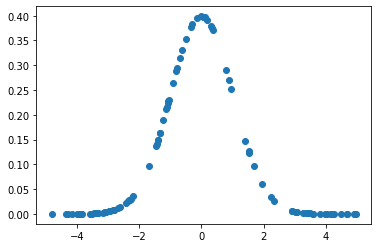

In [ ]:
# get 100 data points
data = get_real_data(100)

# convert to float for dl model
data = data.astype('float32')
plt.scatter(data[:,0], data[:, 1])

# convert your data into tensorflow data type.
train_data = tf.data.Dataset.from_tensor_slices(data)
train_data = train_data.batch(64).prefetch(32)

In [ ]:
# discriminator model
def build_discriminator(n=2):
  inps = layers.Input(shape=(n,))
  x = layers.Dense(25, activation='relu',
                   kernel_initializer='he_uniform')(inps)
  outs = layers.Dense(1)(x)
  model = keras.Model(inps, outs, name='discriminator')
  return model
# generator model
def build_generator(latent_dim=5):
  inps = layers.Input(shape=(latent_dim,))
  x = layers.Dense(25, activation='relu',
                   kernel_initializer='he_uniform')(inps)
  outs = layers.Dense(2, activation='linear')(x)
  model = keras.Model(inps, outs, name='generator')
  return model
discriminator = build_discriminator()
generator = build_generator()
print(discriminator.summary(), generator.summary())

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                150       
____________________________________

In [ ]:
class GAN(keras.Model):
    
  # initialize models with latent dimensions
  def __init__(self, disc, gen, latent_dim=5):
    super(GAN, self).__init__()
    self.discriminator = disc
    self.generator = gen
    self.latent_dim = latent_dim
  
  # compile with optimizers and loss function
  def compile(self, optD, optG, loss_fn):
    super(GAN, self).compile()
    self.optD = optD
    self.optG = optG
    self.loss_fn = loss_fn
    
  # custom training function
  def train_step(self, real_data):
    if isinstance(real_data, tuple):
      real_data = real_data[0]
    
    # get current batch size
    bs = tf.shape(real_data)[0]
    z = tf.random.normal(shape=(bs, self.latent_dim))
    fake_data = self.generator(z)
    
    # combine real and fake images in a single vector along with their labels
    combined_data = tf.concat([real_data, fake_data], axis=0)
    labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)
    
    # train your discriminator
    with tf.GradientTape() as tape:
      preds = self.discriminator(combined_data)
      d_loss = self.loss_fn(labels, preds)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    
    # misleading labels for generator
    misleading_labels = tf.ones((bs, 1))
    z = tf.random.normal(shape=(bs, self.latent_dim))
    
    # train your generator
    with tf.GradientTape() as tape:
      fake_preds = self.discriminator(self.generator(z))
      g_loss = self.loss_fn(misleading_labels, fake_preds)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": d_loss, "g_loss": g_loss}
# create GAN model using already built D and G
gan = GAN(discriminator, generator)
# compile your model with loss and optimizers
gan.compile(
    keras.optimizers.Adam(),
    keras.optimizers.Adam(),
    keras.losses.BinaryCrossentropy(from_logits=True)
)

In [ ]:
# def extract(lst,epoch):
#     for item in lst:
#       return lst[epoch][0]

# def show_samples(epoch, generator, discriminator, data, n=100, l_dim=5):
#   # save results after every 20 epochs  
#   if epoch % 20 == 0:
#     z = tf.random.normal(shape=(n, l_dim))
#     generated_data = generator(z)
#     discriminator_confidence = discriminator(generated_data)
#     generated_data_np = generated_data.numpy()
#     generated_points_list.append(generated_data)
#     decision_boundary.append((extract(generated_data_np,epoch),discriminator_confidence))

# # list for storing generated points
# generated_points_list = []

# decision_boundary = []

# # a lambda callback
# cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, gan.discriminator, data))


In [ ]:
epochs= []

def show_samples(epoch, generator, discriminator, data, n=100, l_dim=5):
  
  
  if epoch % 20 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)

    confidence = np.asarray(discriminator(generated_data))
    #x = np.asarray(generated_points_list[epoch][:,0])
    flat_list = []
    for sublist in confidence:
        for item in sublist:
            flat_list.append(item)
    confidence=flat_list
    

    for i in range (len(z)):
      decision_boundary.append((confidence[i],z[i]))
    


    
# list for storing generated points
generated_points_list = []    

decision_boundary = []

# a lambda callback
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, gan.discriminator, data))


In [ ]:
def show_samples(epoch, generator, data, n=100, l_dim=5):
  # save results after every 20 epochs  
  if epoch % 20 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)

# list for storing generated points
generated_points_list = []
# a lambda callback
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, data))


In [ ]:
# %time hist = gan.fit(train_data, epochs=50, callbacks=[cbk], verbose=False)

In [ ]:
# print(len(generated_points_list),len(decision_boundary))
# print(epochs)
# for e in epochs:
#   print(np.array(generated_points_list[e][:,0]))
#print(generated_points_list)


# print(decision_boundary)
# [i[0] for i in decision_boundary]
# print(decision_boundary[0][1])


CPU times: user 5.02 s, sys: 615 ms, total: 5.64 s
Wall time: 7.05 s


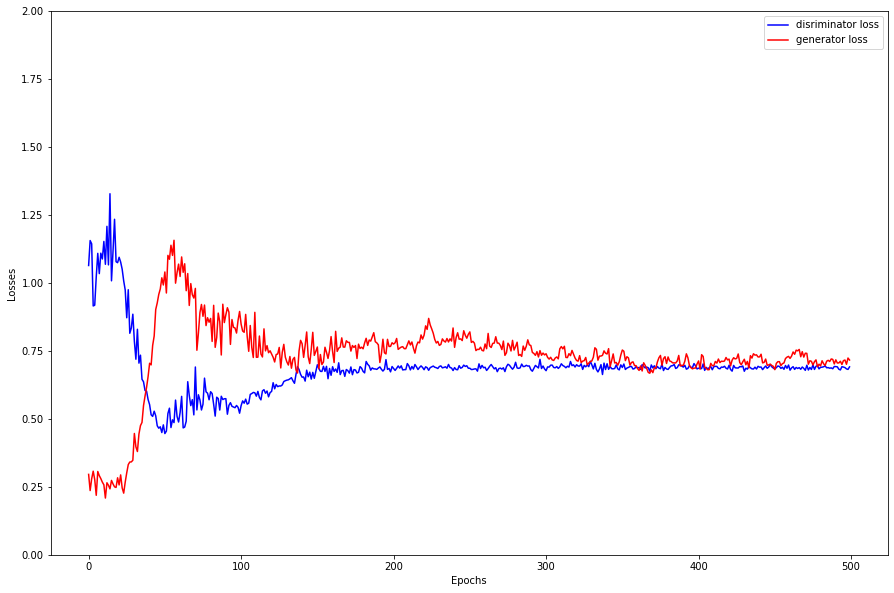

In [ ]:
# time your training
%time hist = gan.fit(train_data, epochs=500, callbacks=[cbk], verbose=False)
'''
this will almost take 40-50 seconds but you can turn on the verbose and see progress along the way
'''
# plot the results
plt.figure(figsize=(15,10))
plt.plot(hist.history['d_loss'], color='blue', label='disriminator loss')
plt.plot(hist.history['g_loss'], color='red', label='generator loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim([0,2])
plt.legend()

In [ ]:
# get real data to show with fake data
real_x, real_y  = data[:, 0], data[:, 1]
camera = Camera(plt.figure())
plt.xlim(real_x.min()-5, real_x.max()+5)
plt.ylim(real_y.min()-0, real_y.max()+0.05)
for i in range(len(generated_points_list)):
  plt.scatter(real_x, real_y, color='blue')
  fake_x, fake_y = generated_points_list[i][:, 0], generated_points_list[i][:, 1]
  plt.scatter(fake_x, fake_y, color='red')
  plt.legend( [f'Époque {i*20}'])
  camera.snap()
anim = camera.animate(blit=True)
plt.close()
# anim.save('animation.gif', fps=2)
anim.save('animation.mp4', fps=10)

In [ ]:
camera = Camera(plt.figure())
for i in range(len(decision_boundary)):
  d_x, d_y = [e[0] for e in decision_boundary], [e[1] for e in decision_boundary]
  print(d_x, d_y)
#   plt.scatter(d_x, d_y, color='grey')
#   plt.legend( [f'Époque {i*20}'])
#   camera.snap()
# anim = camera.animate(blit=True)
# plt.close()
# # anim.save('animation.gif', fps=2)
# anim.save('animation1.mp4', fps=10)

<Figure size 432x288 with 0 Axes>